In [211]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text
from tensorflow import keras
import seaborn as sns

# read model metric data, drop duplicated column
df = pd.read_csv('saved_models/NLP_1/NLP_1.csv')
df = df.drop(labels ="Unnamed: 0", axis=1)
df.head()

,loss,accuracy,epoch
0,2.129587,0.243528,1
1,1.872775,0.370622,2
2,1.719108,0.434345,3
3,1.607369,0.480848,4
4,1.528527,0.514466,5


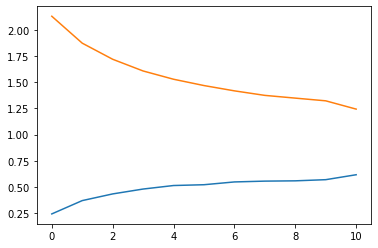

In [212]:
# visualise accuracy after training
plt.plot(df['accuracy'])
plt.plot(df['loss'])

In [213]:
# load the saved model
model =  keras.models.load_model('saved_models/NLP_1/NLP_1_saved_model')

In [214]:
# creat dict to decode predictions
catagory_dict = {'Blockchain':0,
    'Cryptocurrency':1,
    'Genetic engineering':2,
    'Machine learning':3,
    'Nanotechnology':4,
    'Quantum computing':5,
    'Robotics':6,
    'Social engineering':7,
    'Space exploration':8,
    'Virtual reality':9,
}

In [215]:
# read test_data, drop duplicate axis from previous steps
test_data = pd.read_csv('saved_models/NLP_1/NLP_1_test_data.csv')
test_data = test_data.drop(labels ="Unnamed: 0", axis=1)
test_data.sample(5)

,x_test,y_test
1147,dlt is a public ledger where the \ninformation...,1
1667,the theory of deontology was \nformulated by i...,2
2355,large international audit firms themselves for...,0
1495,since averaging is less computa-\ntionally exp...,3
1625,it has been estimated that they will\nneed to ...,0


In [216]:
# use model to predict test dataset, output results to dataframe
predictions = model.predict(test_data['x_test'])
predictions = pd.DataFrame(predictions)
print(predictions.shape)
predictions.head()

(2846, 10)


,0,1,2,3,4,5,6,7,8,9
0,0.428614,0.082903,0.127058,0.645412,0.472324,0.199553,0.786004,0.424367,0.302555,0.840727
1,0.186132,0.127960,0.573506,0.050443,0.603173,0.251124,0.241396,0.313756,0.965983,0.082040
2,0.469551,0.086571,0.157554,0.302771,0.609093,0.391998,0.545739,0.401236,0.416894,0.273100
3,0.464140,0.202253,0.315974,0.266738,0.491500,0.223532,0.853690,0.242381,0.261974,0.449751
4,0.903964,0.703304,0.128915,0.654930,0.553496,0.061180,0.322418,0.456571,0.175625,0.331193


In [217]:
# find column of max for each row and make new column for 'P' Prediction
predictions['P'] = predictions.idxmax(axis = 1)
predictions.head()

,0,1,2,3,4,5,6,7,8,9,P
0,0.428614,0.082903,0.127058,0.645412,0.472324,0.199553,0.786004,0.424367,0.302555,0.840727,9
1,0.186132,0.127960,0.573506,0.050443,0.603173,0.251124,0.241396,0.313756,0.965983,0.082040,8
2,0.469551,0.086571,0.157554,0.302771,0.609093,0.391998,0.545739,0.401236,0.416894,0.273100,4
3,0.464140,0.202253,0.315974,0.266738,0.491500,0.223532,0.853690,0.242381,0.261974,0.449751,6
4,0.903964,0.703304,0.128915,0.654930,0.553496,0.061180,0.322418,0.456571,0.175625,0.331193,0


In [218]:
# append actual encoded values as 'A'
predictions['A'] = test_data['y_test']
predictions.head()

,0,1,2,3,4,5,6,7,8,9,P,A
0,0.428614,0.082903,0.127058,0.645412,0.472324,0.199553,0.786004,0.424367,0.302555,0.840727,9,9
1,0.186132,0.127960,0.573506,0.050443,0.603173,0.251124,0.241396,0.313756,0.965983,0.082040,8,8
2,0.469551,0.086571,0.157554,0.302771,0.609093,0.391998,0.545739,0.401236,0.416894,0.273100,4,9
3,0.464140,0.202253,0.315974,0.266738,0.491500,0.223532,0.853690,0.242381,0.261974,0.449751,6,6
4,0.903964,0.703304,0.128915,0.654930,0.553496,0.061180,0.322418,0.456571,0.175625,0.331193,0,0


In [237]:
# make new dataframe of just P and A
results = predictions[['P','A']]
results.head()

,P,A
0,9,9
1,8,8
2,4,9
3,6,6
4,0,0


In [238]:
# calculate a frequency value for each P/A pair
results = results.groupby(results.columns.tolist(),as_index=False).size()
results.head()


,P,A,size
0,0,0,267
1,0,1,75
2,0,2,2
3,0,3,21
4,0,4,27


In [240]:
# convert to numpy array for insertion into matrix
results_array = results.to_numpy()

In [241]:
#generate confusion matrix grid (10 x 10)
mtx = {}
for i in range(10):
    for x in range(10):    
        mtx[i] = {i:np.NaN}
mtx = pd.DataFrame(mtx)
mtx.shape

(10, 10)

In [242]:
# iterate over the np array, use the P/A values as coordinates to insert the respective size value
# any missing values will remain as NaN. once filled, replace NaN with 0 for the heatmap.
# matrix is represented with Predictions on the x axis (columns) and True values on the y axis (rows)
for item in results_array:
    mtx[item[0]][item[1]] = item[2]
mtx = mtx.replace(np.NaN, 0)
mtx

,0,1,2,3,4,5,6,7,8,9
0,267.0,19.0,6.0,11.0,46.0,11.0,8.0,7.0,12.0,1.0
1,75.0,178.0,2.0,4.0,22.0,12.0,7.0,9.0,11.0,2.0
2,2.0,1.0,137.0,5.0,46.0,11.0,3.0,1.0,22.0,0.0
3,21.0,1.0,2.0,58.0,26.0,28.0,7.0,4.0,2.0,10.0
4,27.0,5.0,20.0,0.0,299.0,8.0,4.0,10.0,22.0,0.0
5,17.0,2.0,10.0,7.0,18.0,329.0,1.0,2.0,23.0,2.0
6,3.0,1.0,7.0,7.0,24.0,5.0,145.0,21.0,3.0,12.0
7,9.0,4.0,8.0,3.0,43.0,2.0,13.0,116.0,12.0,4.0
8,6.0,3.0,7.0,37.0,36.0,38.0,5.0,7.0,186.0,2.0
9,9.0,2.0,1.0,12.0,10.0,9.0,41.0,15.0,9.0,66.0


In [243]:
# calculate adjustment values as a ratio of y_test_count/total_count present in the test dataset
counts = test_data.groupby('y_test', as_index=False).size()
counts.rename(columns = {'size':'y_test_count'}, inplace=True)
total_count = len(test_data)
counts["adjustment_factor"] = counts['y_test_count']/total_count
counts

,y_test,y_test_count,adjustment_factor
0,0,388,0.136332
1,1,322,0.113141
2,2,228,0.080112
3,3,159,0.055868
4,4,395,0.138791
5,5,411,0.144413
6,6,228,0.080112
7,7,214,0.075193
8,8,327,0.114898
9,9,174,0.061138


In [244]:
# transpose matrix to apply adjustment along the True value axis 
# apply the adjustment factor along columns
mtx = mtx.T
mtx = mtx*counts["adjustment_factor"]
mtx

,0,1,2,3,4,5,6,7,8,9
0,36.400562,8.485594,0.160225,1.173226,3.747365,2.455025,0.240337,0.676739,0.689389,0.550246
1,2.590302,20.139143,0.080112,0.055868,0.693956,0.288826,0.080112,0.300773,0.344694,0.122277
2,0.817990,0.226283,10.975404,0.111736,2.775826,1.444132,0.560787,0.601546,0.804287,0.061138
3,1.499649,0.452565,0.400562,3.240337,0.000000,1.010892,0.560787,0.225580,4.251230,0.733661
4,6.271258,2.489108,3.685172,1.452565,41.498595,2.599438,1.922699,3.233310,4.136332,0.611384
5,1.499649,1.357695,0.881237,1.564301,1.110330,47.511947,0.400562,0.150387,4.366128,0.550246
6,1.090654,0.791989,0.240337,0.391075,0.555165,0.144413,11.616304,0.977512,0.574491,2.506676
7,0.954322,1.018271,0.080112,0.223472,1.387913,0.288826,1.682361,8.722417,0.804287,0.917077
8,1.635980,1.244554,1.762474,0.111736,3.053408,3.321504,0.240337,0.902319,21.371047,0.550246
9,0.136332,0.226283,0.000000,0.558679,0.000000,0.288826,0.961349,0.300773,0.229796,4.035137


<AxesSubplot:>

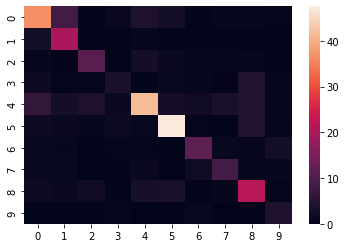

In [245]:
# visualise the confusion matrix using a heatmap
sns.heatmap(mtx)